In [1]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset

# Simulate the Lorenz system

The Lorenz system is a system of ordinary differential equations first studied by Edward Lorenz. It is notable for having chaotic solutions for certain parameter values and initial conditions. In particular, the Lorenz attractor is a set of chaotic solutions of the Lorenz system which, when plotted, resemble a butterfly or figure eight.

The Lorenz system is given by the following differential equations:

$$
\begin{aligned}
\frac{dx}{dt} &= \sigma(y - x) \\
\frac{dy}{dt} &= x(\rho - z) - y \\
\frac{dz}{dt} &= xy - \beta z
\end{aligned}
$$

where $x$, $y$, and $z$ are the state variables, and $\sigma$, $\rho$, and $\beta$ are the system parameters.


In [51]:
def lorenz_system(state, t, sigma=10, rho=28, beta=8/3):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Generate data using odeint
np.random.seed(0)
torch.manual_seed(0)
t = np.linspace(0, 100, 5000)  # Time vector
initial_state = [1.0, 1.0, 1.0]
lorenz_data = odeint(lorenz_system, initial_state, t)
x_data = lorenz_data[:, 0]
sequence_length = 1

# Do a 60, 20, 20 split for training, validation, and testing
train_data = lorenz_data[:int(0.6 * len(lorenz_data))]
val_data = lorenz_data[int(0.6 * len(lorenz_data)):int(0.8 * len(lorenz_data))]
test_data = lorenz_data[int(0.8 * len(lorenz_data)):]

# Normalize data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data = scaler.fit_transform(train_data)
val_data = scaler.transform(val_data)
test_data = scaler.transform(test_data)


# Create a custom dataset for the Lorenz system

In this notebook, we will create a custom dataset for the Lorenz system. We will simulate the Lorenz system for a given set of parameters and initial conditions, and then use the simulated data to train a neural network to predict the future state of the system. In this case the history will just be the current state, but this can be easily extended to include more history using the `sequence_length` parameter from above.

In [38]:
# Custom Dataset Class
class LorenzDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.sequence_length] 
        y = self.data[idx + self.sequence_length]
        return (
            torch.tensor(x, dtype=torch.float32),
            torch.tensor(y, dtype=torch.float32),
        )

train_dataset = LorenzDataset(train_data, sequence_length)
val_dataset = LorenzDataset(val_data, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define our model structures

We will compare a simple feedforward neural network/multilayer perceptron (MLP) with a recurrent neural network (RNN) to predict the future state of the Lorenz system. Both models will take some past history of the system as input and predict the next state of the system.

In [39]:
class RNNModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=8, num_layers=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)
        self.hidden = None

    def forward(self, x, hidden=None):
        out, self.hidden = self.rnn(x, hidden)
        out = self.fc(out[:, -1, :])  # Only use the output at the last time step
        return out

class MLPModel(nn.Module):
    def __init__(self, input_size=sequence_length*3, hidden_size=8):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the training routine

The function below will train the model on the simulated data and return the training and validation metrics. This is a standard training routine that can be used for many neural network models & datasets.

In [41]:
def train_model(model, optimizer, train_loader, val_loader, loss_fn, device, n_epochs=100):
    all_train_loss = []
    all_val_loss = []
    model.train()
    for epoch in range(n_epochs):
        train_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            # Forward pass
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        all_train_loss.append(train_loss / len(train_loader))
        
        # Validation after each epoch
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                y_pred = model(x_val)
                val_loss += loss_fn(y_pred, y_val).item()
        val_loss /= len(val_loader)
        all_val_loss.append(val_loss)
        print(f"Epoch [{epoch+1}/{n_epochs}], Val Loss: {val_loss:.4f}")
        model.train()
    return pd.DataFrame({
        'train_loss': all_train_loss, 
        'val_loss': all_val_loss
    })


Training RNN...
Epoch [1/100], Val Loss: 0.0270
Epoch [2/100], Val Loss: 0.0053
Epoch [3/100], Val Loss: 0.0037
Epoch [4/100], Val Loss: 0.0026
Epoch [5/100], Val Loss: 0.0016
Epoch [6/100], Val Loss: 0.0010
Epoch [7/100], Val Loss: 0.0007
Epoch [8/100], Val Loss: 0.0006
Epoch [9/100], Val Loss: 0.0005
Epoch [10/100], Val Loss: 0.0005
Epoch [11/100], Val Loss: 0.0004
Epoch [12/100], Val Loss: 0.0004
Epoch [13/100], Val Loss: 0.0004
Epoch [14/100], Val Loss: 0.0004
Epoch [15/100], Val Loss: 0.0003
Epoch [16/100], Val Loss: 0.0003
Epoch [17/100], Val Loss: 0.0003
Epoch [18/100], Val Loss: 0.0003
Epoch [19/100], Val Loss: 0.0003
Epoch [20/100], Val Loss: 0.0003
Epoch [21/100], Val Loss: 0.0003
Epoch [22/100], Val Loss: 0.0003
Epoch [23/100], Val Loss: 0.0003
Epoch [24/100], Val Loss: 0.0003
Epoch [25/100], Val Loss: 0.0002
Epoch [26/100], Val Loss: 0.0002
Epoch [27/100], Val Loss: 0.0002
Epoch [28/100], Val Loss: 0.0003
Epoch [29/100], Val Loss: 0.0002
Epoch [30/100], Val Loss: 0.0002
Epo

# Create our models, loss function, and optimizers

The models from above are initialized here, and we also define the loss function and optimizer for training the models. This is set up in a fairly standard way, with the mean squared error loss and the Adam optimizer.

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hidden_size = 8
rnn_model = RNNModel(input_size=3, hidden_size=hidden_size).to(device)
mlp_model = MLPModel(input_size=3*sequence_length, hidden_size=hidden_size).to(device)

loss_fn = nn.MSELoss()
rnn_optimizer = optim.AdamW(rnn_model.parameters(), lr=0.005)
mlp_optimizer = optim.AdamW(mlp_model.parameters(), lr=0.005)


In [ ]:

print("Training RNN...")
rnn_loss_df = train_model(rnn_model, rnn_optimizer, train_loader, val_loader, loss_fn, device)

print("Training MLP...")
mlp_loss_df = train_model(mlp_model, mlp_optimizer, train_loader, val_loader, loss_fn, device)

[]

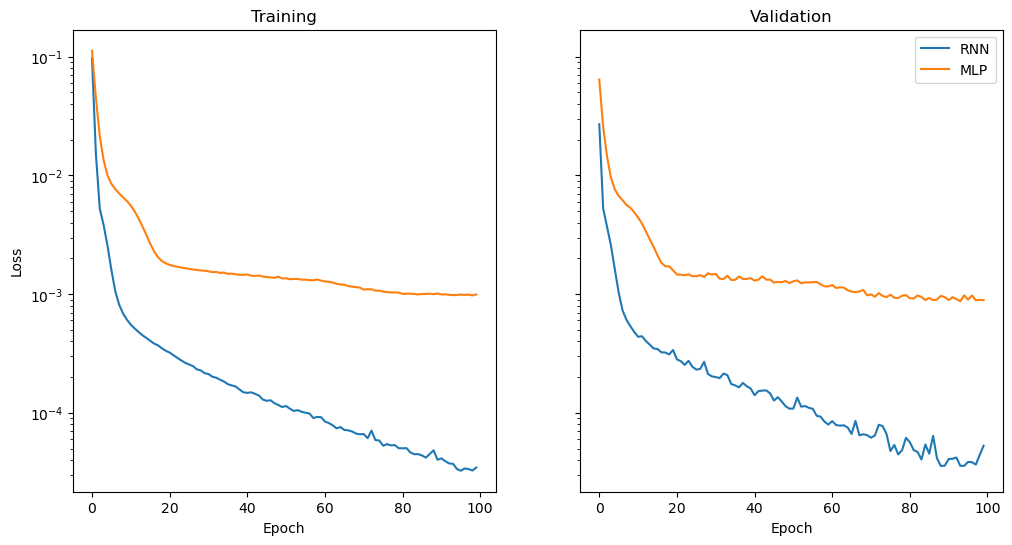

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

rnn_loss_df['train_loss'].plot(ax=axes[0], title='Training')
mlp_loss_df['train_loss'].plot(ax=axes[0], title='Training')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

rnn_loss_df['val_loss'].plot(ax=axes[1], title='Validation')
mlp_loss_df['val_loss'].plot(ax=axes[1], title='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')

axes[1].legend(['RNN', 'MLP'])
axes[0].semilogy()
axes[1].semilogy()


In [43]:
def generate_predictions(model, dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_pred = model(x_batch)
            predictions.append(y_pred.cpu().numpy())
    return np.concatenate(predictions)

rnn_predictions = generate_predictions(rnn_model, val_loader)
mlp_predictions = generate_predictions(mlp_model, val_loader)

Text(0.5, 0, 'Time')

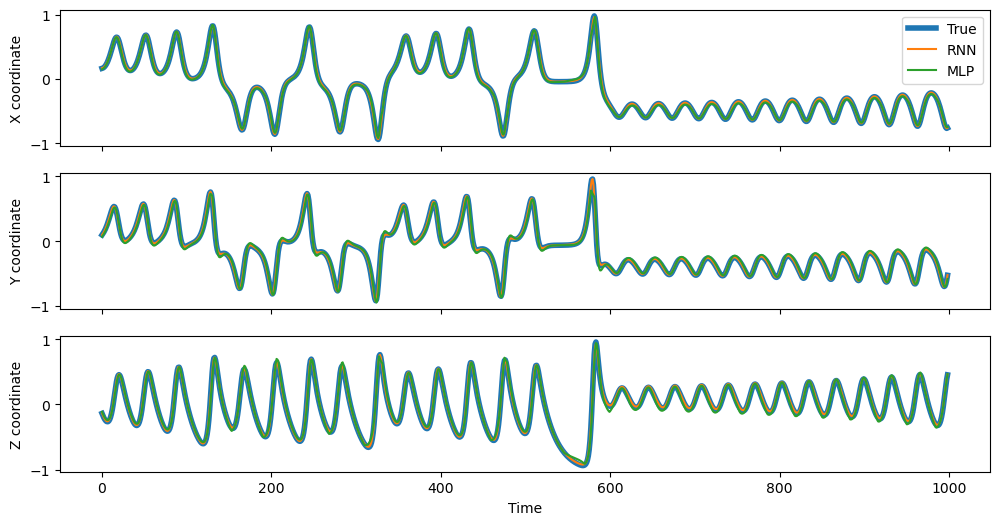

In [50]:
fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

for i in range(3):
    axes[i].plot(val_data[sequence_length:, i], label='True', linewidth=4)
    axes[i].plot(rnn_predictions[:, i], label='RNN')
    axes[i].plot(mlp_predictions[:, i], label='MLP')

axes[0].legend()
axes[0].set_ylabel('X coordinate')
axes[1].set_ylabel('Y coordinate')
axes[2].set_ylabel('Z coordinate')
axes[2].set_xlabel('Time')


In [45]:
x_init = val_data[:sequence_length]
x_init.shape

forecast_length = 300

rnn_pred= []
mlp_pred = []
x_next = torch.from_numpy(x_init).unsqueeze(0).to(device).to(torch.float32)
with torch.no_grad():
    for _ in range(forecast_length):
        pred = rnn_model(x_next)
        x_next = torch.cat([x_next[:, 1:, :], pred.unsqueeze(1)], axis=1)
        rnn_pred.append(pred.cpu().numpy())

x_next = torch.from_numpy(x_init).unsqueeze(0).to(device).to(torch.float32)
with torch.no_grad():
    for _ in range(forecast_length):
        pred = mlp_model(x_next)
        x_next = torch.cat([x_next[:, 1:, :], pred.unsqueeze(1)], axis=1)
        mlp_pred.append(pred.cpu().numpy())


In [46]:
rnn_pred = np.concatenate(rnn_pred, axis=0)
mlp_pred = np.concatenate(mlp_pred, axis=0)
true_traj = val_data[sequence_length:sequence_length+forecast_length]

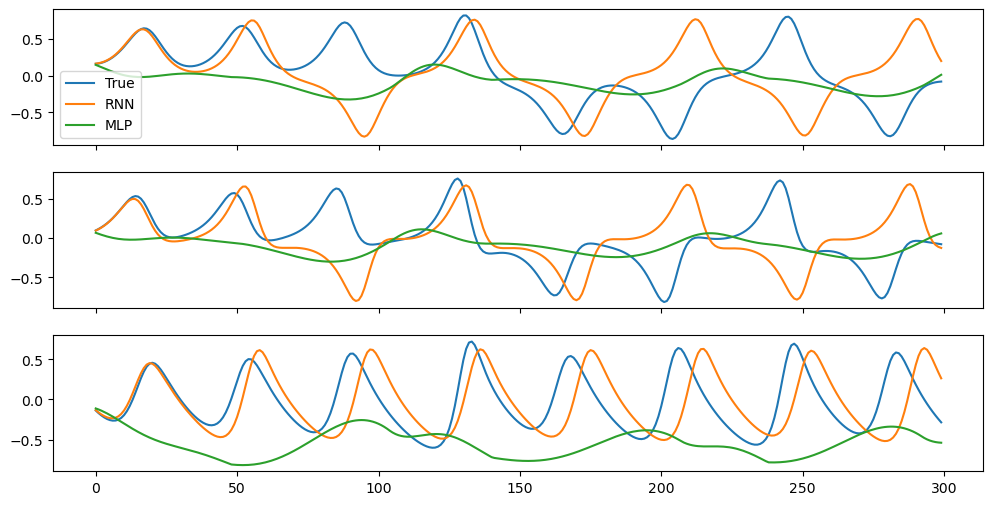

In [47]:
fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

for i in range(3):
    axes[i].plot(true_traj[:, i], label='True')
    axes[i].plot(rnn_pred[:, i], label='RNN')
    axes[i].plot(mlp_pred[:, i], label='MLP')

axes[0].legend(['True', 'RNN', 'MLP'])